#### <u> <font color=blue> Load Libraries </font>  </u>

In [33]:
# Let's load the packages
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import scipy.stats as stats
from scipy.stats import kde
import statsmodels
from sklearn import metrics
from statsmodels.stats.multitest import multipletests
# import natsort

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [34]:
import sklearn
sklearn.__version__

import umap.plot
umap.__version__

'0.5.3'

###### <u> <font color=blue> Set Paths </font>  </u>

In [35]:
PATH = os.path.join(os.getcwd())
PATH_DATA = os.path.join(PATH, 'Data')


#### <u> <font color=blue> Functions </font>  </u>

In [36]:
def plot_reduction(df):
    plt.figure(figsize=(5,5))
    sns.scatterplot(
        x="Component 1", y="Component 2",
        hue="cluster",
        palette='Set1',
        data=df,
        marker = 'o',
        s=70,
        # edgecolor=None
        edgecolor="grey"
    )

    #plt.axis('off')
    plt.legend(frameon=False)
    #plt.savefig("pca_kmeans.pdf", bbox_inches='tight')

def get_pca(X):
    pca = PCA(n_components=2, random_state=42)
    principalComponents = pca.fit_transform(X.iloc[:, :-1])
    PCA_components = pd.DataFrame(principalComponents)
    df_pca = pd.DataFrame()
    df_pca['Component 1'] = PCA_components[0]
    df_pca['Component 2'] = PCA_components[1]
    df_pca['cluster'] = X['labels'].values
    return df_pca

def get_umap(X):
    import umap.plot
    reducer = umap.UMAP(random_state=0)
    embedding = reducer.fit_transform(X.iloc[:, :-1]) ##Select data without labels
    df_umap = pd.DataFrame()
    df_umap['Component 1'] = embedding[:,0]
    df_umap['Component 2'] = embedding[:,1]
    df_umap['cluster'] = X['labels'].values
    mapper = umap.UMAP(random_state=42).fit(X.iloc[:, :-1])
    return df_umap


def kmeans(X, n_clusters):
    ## Run Kmeans on data matrix
    kmeans = KMeans(init="random", n_clusters=n_clusters, random_state=42).fit(X)
    clusters = kmeans.labels_
    return clusters
    

#### <u> <font color=blue> Load Data </font>  </u>

In [37]:
## Normalized counts
counts = pd.read_csv( 'Data/normalized_gene_counts.csv').set_index(['Unnamed: 0'])
counts.columns = counts.columns.astype(int)
print(counts.shape)


(13214, 443)


In [38]:
## Load meta data
meta = pd.read_csv(os.path.join(PATH_DATA, 'metadata.tsv'), sep='\t').set_index(['Unnamed: 0'])#.set_index(['vid'])
meta = meta.loc[counts.columns.astype(int)]
meta = meta[meta.condition.notna()]
counts = counts[meta.index]


In [39]:
counts.shape, meta.shape

((13214, 192), (192, 12))

#### <u> <font color=blue> Clustering (PCA) </font>  </u>

In [40]:
vitd_genes = ['VDR', 'VDRE', 
              ## GO
              'CYP2R1','CYP24A1', 'CYP27A1', 'CYP27B1', 'ENPP1', 'FGF23','FGFR1', 'FGFR4','GC','GFI1','IFNG','LRP2','NFKB1','SNAI1','SNAI2','TNF', 
              ## WikiPathways
              'ABCB1', 'ABCA11', 'ABCD1', 'ADAMTS5', 'ADGRE5', 'ADRA1B', 'ADRB2', 'ALOX5', 'ALPG', 'ALPI',
              'ASAP2', 'ATP2B1', 'ATP2C2', 'BCL6', 'BDKRB1', 'BGLAP', 'BMP6', 'BTLA', 'CA9', 'CALB1', 'CAMP',
              'CASP14', 'CASP5', 'CBS', 'CCNC', 'CCND1', 'CCNE1', 'CD14', 'CD200', 'CD40', 'CD9', 'CDC34', 'CDK2',
              'CDKAL1', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'CDKN2D', 'CDX2', 'CEACAM1', 'CEBPA',
              'CLDN2', 'CLEC16A', 'CLMN', 'CLPTM1L', 'COLEC11', 'CRACR2A', 'CRACR2B', 'CREG2', 'CST1', 'CST6', 
              'CTLA4', 'CYP1A1', 'CYP24A1', 'CYP27B1', 'CYP2B6', 'CYP2C9', 'CYP2D6', 'CYP2S1', 'CYP3A4', 'CYP3A5',
              'CYP7A1', 'COL13A1', 'DACT2', 'DEFB109C', 'DEFB132', 'DEFB4A', 'DND1', 'DNER', 'DUSP10', 'EFNA5',
              'EPHB4', 'FGF23', 'FOXO1', 'G0S2', 'G6PD', 'GADD45A', 'GXYLT2', 'HIF1A', 'HILPDA', 'HLA-DQA1', 'HLA-DRB1',
              'HNF1A', 'HSD17B2', 'ID1', 'ID4', 'IGFBP1', 'IGFBP3', 'IGFBP5', 'IGSF9B', 'IL12A', 'IL1RL1', 'IL25', 'IRF4',
              'IRF5', 'IRF8', 'ITGAM', 'JUNB', 'KL', 'KLF4', 'KLK6', 'KNG1', 'KRT13', 'KRT16', 'KRT34', 'KRT38', 'KRT71',
              'KRTAP10-2', 'KRTAP10-4', 'KRTAP10-7', 'KRTAP10-9', 'KRTAP12-2', 'KRTAP4-1', 'KRTAP5-1', 'KRTAP5-4', 'KRTAP8-1',
              'LCE1D', 'LCE1F', 'LCE2B', 'LGALS9', 'LPGAT1', 'LRP5', 'LRRC25', 'LRRC8A', 'Ligand', 'MED9', 'MEG8', 'MX2', 
              'MXD1', 'MYC', 'MYO9B', 'NFATC2', 'NINJ1', 'NOX1', 'NRIP1', 'ORM1', 'ORM2', 'PNOC', 'PPARD', 'PRDM1', 'PRKCQ',
              'PTGER4', 'PTH', 'PTHLH', 'RASGRP1', 'RXRA', 'S100A2', 'S100A4', 'S100A6', 'S100A8', 'S100A9', 'S100G', 'SALL4',
              'SATB1', 'SEMA3B', 'SERPINB1', 'SFRP1', 'SLC2A4', 'SLC34A2', 'SLC37A2', 'SLC8A1', 'SOSTDC1', 'SPP1', 'SPRR1B', 'STAM', 
              'STEAP4', 'STS', 'SULT1C2', 'SULT2A1', 'TGFB1', 'TGFB2', 'THBD', 'TIMP2', 'TIMP3', 'TNFAIP3', 'TNFRSF11B', 'TNFSF11',
              'TNFSF4', 'TPM1', 'TRAK1', 'TREM1', 'TRPV5', 'TRPV6','VDR', 'ZNF257']

print(len(set(vitd_genes)))
annot = pd.read_csv(os.path.join(PATH_DATA, 'Annotations.tsv'),sep='\t')
goi = annot[annot.hgnc_symbol.isin(vitd_genes)]

data = counts.loc[list(set(counts.index) & set(goi.ensembl_gene_id))]


201


In [41]:
data = data.T
frame = pd.DataFrame(data)
num_clusters = 2
labels = kmeans(data, n_clusters = num_clusters)
frame['labels'] = labels

# df_pca = get_umap(frame)
# plot_reduction(df_pca)



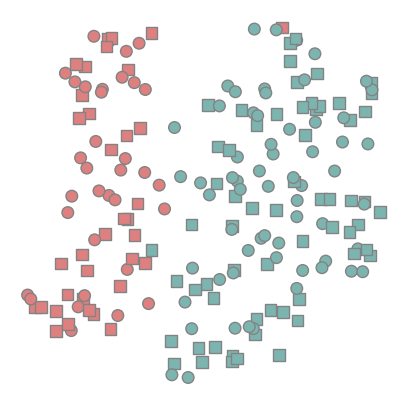

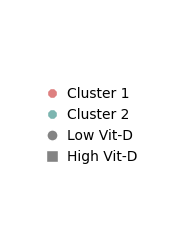

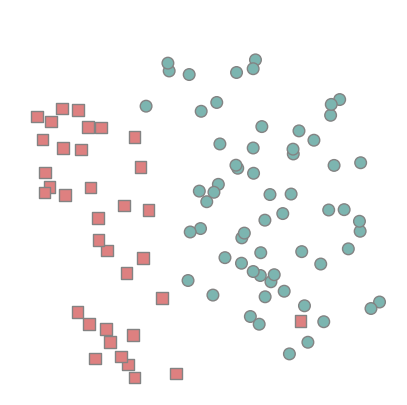

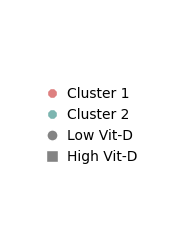

In [42]:
from matplotlib.lines import Line2D
def plot_reduction(df, filename, sizes = False):
    palette = ["#de8080",#"#ca8f80",
               '#7cb5b0']
    kwargs  =  {'edgecolor':"#838383",'linewidth':1} ##929292
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    
    # Plot the scatterplot
    plot = sns.scatterplot(
        x="Component 1", y="Component 2",
        hue="cluster",
        style="condition",
        palette=palette,
        data=df,
        markers=['o', 's'], # Assign different shapes
        s=sizes if sizes else 70,
        **kwargs
    )
    
    plt.legend(frameon=False)
    plt.axis('off')
    plt.legend('',frameon=False)
    plt.savefig(filename, bbox_inches='tight')
    
    # Retrieve handles and labels for the legend
    handles, labels = ax.get_legend_handles_labels()
    
    # Define new labels for your legend
    new_labels = ['Cluster 1', 'Cluster 2', 'Low Vit-D', 'High Vit-D']
    custom_markers = ['8', '8', 'o', 's'] 
    
    # Assuming that your colors for clusters and conditions are palette[0] and palette[1]
    cluster_colors = [palette[0], palette[1]]
    condition_colors = ['#838383', '#838383']  # Define colors for Low and High Vit-D
    
    # Create custom handles for the legend
    new_handles = [
        Line2D([], [], marker=custom_markers[0], color='w', markerfacecolor=cluster_colors[0], markersize=8),
        Line2D([], [], marker=custom_markers[1], color='w', markerfacecolor=cluster_colors[1], markersize=8),
        Line2D([], [], marker=custom_markers[2], color='w', markerfacecolor=condition_colors[0], markersize=8),
        Line2D([], [], marker=custom_markers[3], color='w', markerfacecolor=condition_colors[1], markersize=8)
    ]
    

    # Create a new figure for the legend
    legend_fig = plt.figure(figsize=(2, 3))
    legend_ax = legend_fig.add_subplot(111)
    
    # Create the legend with the custom labels and without the frame
    legend_ax.legend(new_handles, new_labels, loc='center', frameon=False, handletextpad=0.1)
    legend_ax.axis('off')
    
    # Save the legend as a separate figure
    legend_fig.savefig('Figures/custom_legend.pdf', bbox_inches='tight', pad_inches=0)
    
    plt.show()
    # Close the figures to avoid display issues
    plt.close('all')

    
def get_umap(X):
    import umap.plot
    reducer = umap.UMAP(random_state = 0) #3#13)#113
    embedding = reducer.fit_transform(X.iloc[:, :-1]) ##Select data without labels
    df_umap = pd.DataFrame()
    df_umap['Component 1'] = embedding[:,0]
    df_umap['Component 2'] = embedding[:,1]
    df_umap['cluster'] = X['labels'].values
    df_umap['condition'] = X['condition'].values
    mapper = umap.UMAP(random_state=42).fit(X.iloc[:, :-2])
    return df_umap

frame['condition'] = meta.loc[frame.index,'condition']
df_pca = get_umap(frame)
plot_reduction(df_pca, filename = 'Figures/umap1.pdf')

frame['condition'] = meta.loc[frame.index,'condition']
frame['sizes'] = np.logical_xor(frame['condition'], frame['labels']).astype(int)
df_pca = get_umap(frame)
plot_reduction(df_pca,filename = 'Figures/umap2.pdf', sizes = list(frame['sizes'].values*70) )



In [43]:
len(labels)

192

In [44]:
new_meta = pd.DataFrame(meta)
#new_meta = meta.fillna(meta.mean())
new_meta['clusters'] = labels

for i in range(num_clusters):
    df = new_meta[new_meta['clusters']==i]
    print('Cluster', i,':',df.shape[0])
    print('Mean Vit. D: ', df.mayocbloodvitd.mean())
    print(df.condition.value_counts()) ##[['trmt','anyAsthma','condition','pseudoEvent']]
    print(0, df[df.condition == 0].shape[0], df[df.condition == 0].mayocbloodvitd.mean(),df[df.condition == 0].mayocbloodvitd.min(), df[df.condition == 0].mayocbloodvitd.max())
    print(1, df[df.condition == 1].shape[0], df[df.condition == 1].mayocbloodvitd.mean(), df[df.condition == 1].mayocbloodvitd.min(), df[df.condition == 1].mayocbloodvitd.max())
    print('****************************************************')

    

Cluster 0 : 68
Mean Vit. D:  23.83970588235294
1.0    35
0.0    33
Name: condition, dtype: int64
0 33 9.821212121212122 2.0 24.0
1 35 37.05714285714286 25.0 68.0
****************************************************
Cluster 1 : 124
Mean Vit. D:  23.50483870967742
1.0    62
0.0    62
Name: condition, dtype: int64
0 62 11.929032258064517 2.0 24.0
1 62 35.08064516129032 25.0 58.0
****************************************************


<font color=red> Cluster 0 and cluster 3 contain majority of patients with maximum difference in mean vitamin D. The difference in mean arises from maximum patients belonging to low (<15) vit. D or high (>15) vit. D </font> 

In [45]:
### Cluster 0 stats
print('Patients with low Vit. D in Cluster 0: ', new_meta[new_meta['clusters']==0].condition.value_counts()[1])

### Cluster 3 stats
print('Patients with high Vit. D in Cluster 1: ', new_meta[new_meta['clusters']==1].condition.value_counts()[0])



Patients with low Vit. D in Cluster 0:  35
Patients with high Vit. D in Cluster 1:  62


In [46]:
group1 = new_meta[(new_meta['clusters']==0) & (new_meta.condition == 1)].index
group2 = new_meta[(new_meta['clusters']==1) & (new_meta.condition == 0)].index
print(len(group1), len(group2))
patient_ids = list(group1) + list(group2) 
meta_subset = meta.loc[patient_ids]
meta_subset.condition = np.nan
meta_subset.loc[list(group1),'condition'] = 'High'
meta_subset.loc[list(group2),'condition'] = 'Low'
meta_subset = meta_subset[meta_subset.condition.notna()]

meta_subset.to_csv( os.path.join(PATH_DATA,'meta_subset.tsv'),sep='\t')

35 62


In [47]:
meta_subset.shape

(97, 13)

### Only these two clusters have differential expression of VDR. Thus, we pick them for downstream analysis.

In [48]:
meta_subset.condition.value_counts()

Low     62
High    35
Name: condition, dtype: int64